<a href="https://colab.research.google.com/drive/1HJlKg2uve_1qx4v-gB0zuZDR2zNjF3iK">Abre este Jupyter en Google Colab</a>

# Caso Práctico: Distribución Gaussiana

## Conjunto de datos: Detección de transacciones bancarias fraudulentas

### Descripción
The datasets contains transactions made by credit cards in September 2013 by european cardholders. 
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

### Descarga de los ficheros de datos
https://www.kaggle.com/mlg-ulb/creditcardfraud#creditcard.csv

### Referencias adicionales sobre el conjunto de datos
_The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection.
More details on current and past projects on related topics are available on https://www.researchgate.net/project/Fraud-detection-5 and the page of the DefeatFraud project._

## Imports

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.gridspec as gridspec
from collections import Counter
from sklearn import metrics
import numpy as np
from matplotlib.colors import LogNorm
from sklearn.metrics import f1_score

In [3]:
import warnings
# Ignoramos algunos warnings que se producen por invocar el modelo sin el nombre de las características
warnings.filterwarnings('ignore', category=UserWarning, message='.*X does not have valid feature names.*')

## 1. Lectura del conjunto de datos

In [4]:
df = pd.read_csv("datasets/creditcard.csv")

## 2. Visualización del conjunto de datos

In [5]:
df.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [6]:
print("Número de características:", len(df.columns))
print("Longitud del conjunto de datos:", len(df))

Número de características: 31
Longitud del conjunto de datos: 284807


In [8]:
# 492 transacciones fraudulentas, 284315 transacciones legitimas
# El conjunto de datos se encuntra desequilabrado
df["Class"].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [9]:
# Visualizamos los tipos de cada uno de los atributos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [10]:
# Comprobamos si alguna columna tiene valores nulos
df.isna().any()

Time      False
V1        False
V2        False
V3        False
V4        False
V5        False
V6        False
V7        False
V8        False
V9        False
V10       False
V11       False
V12       False
V13       False
V14       False
V15       False
V16       False
V17       False
V18       False
V19       False
V20       False
V21       False
V22       False
V23       False
V24       False
V25       False
V26       False
V27       False
V28       False
Amount    False
Class     False
dtype: bool

In [11]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.175161e-15,3.384974e-16,-1.379537e-15,2.094852e-15,1.021879e-15,1.494498e-15,-5.620335e-16,1.149614e-16,-2.414189e-15,...,1.628620e-16,-3.576577e-16,2.618565e-16,4.473914e-15,5.109395e-16,1.686100e-15,-3.661401e-16,-1.227452e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


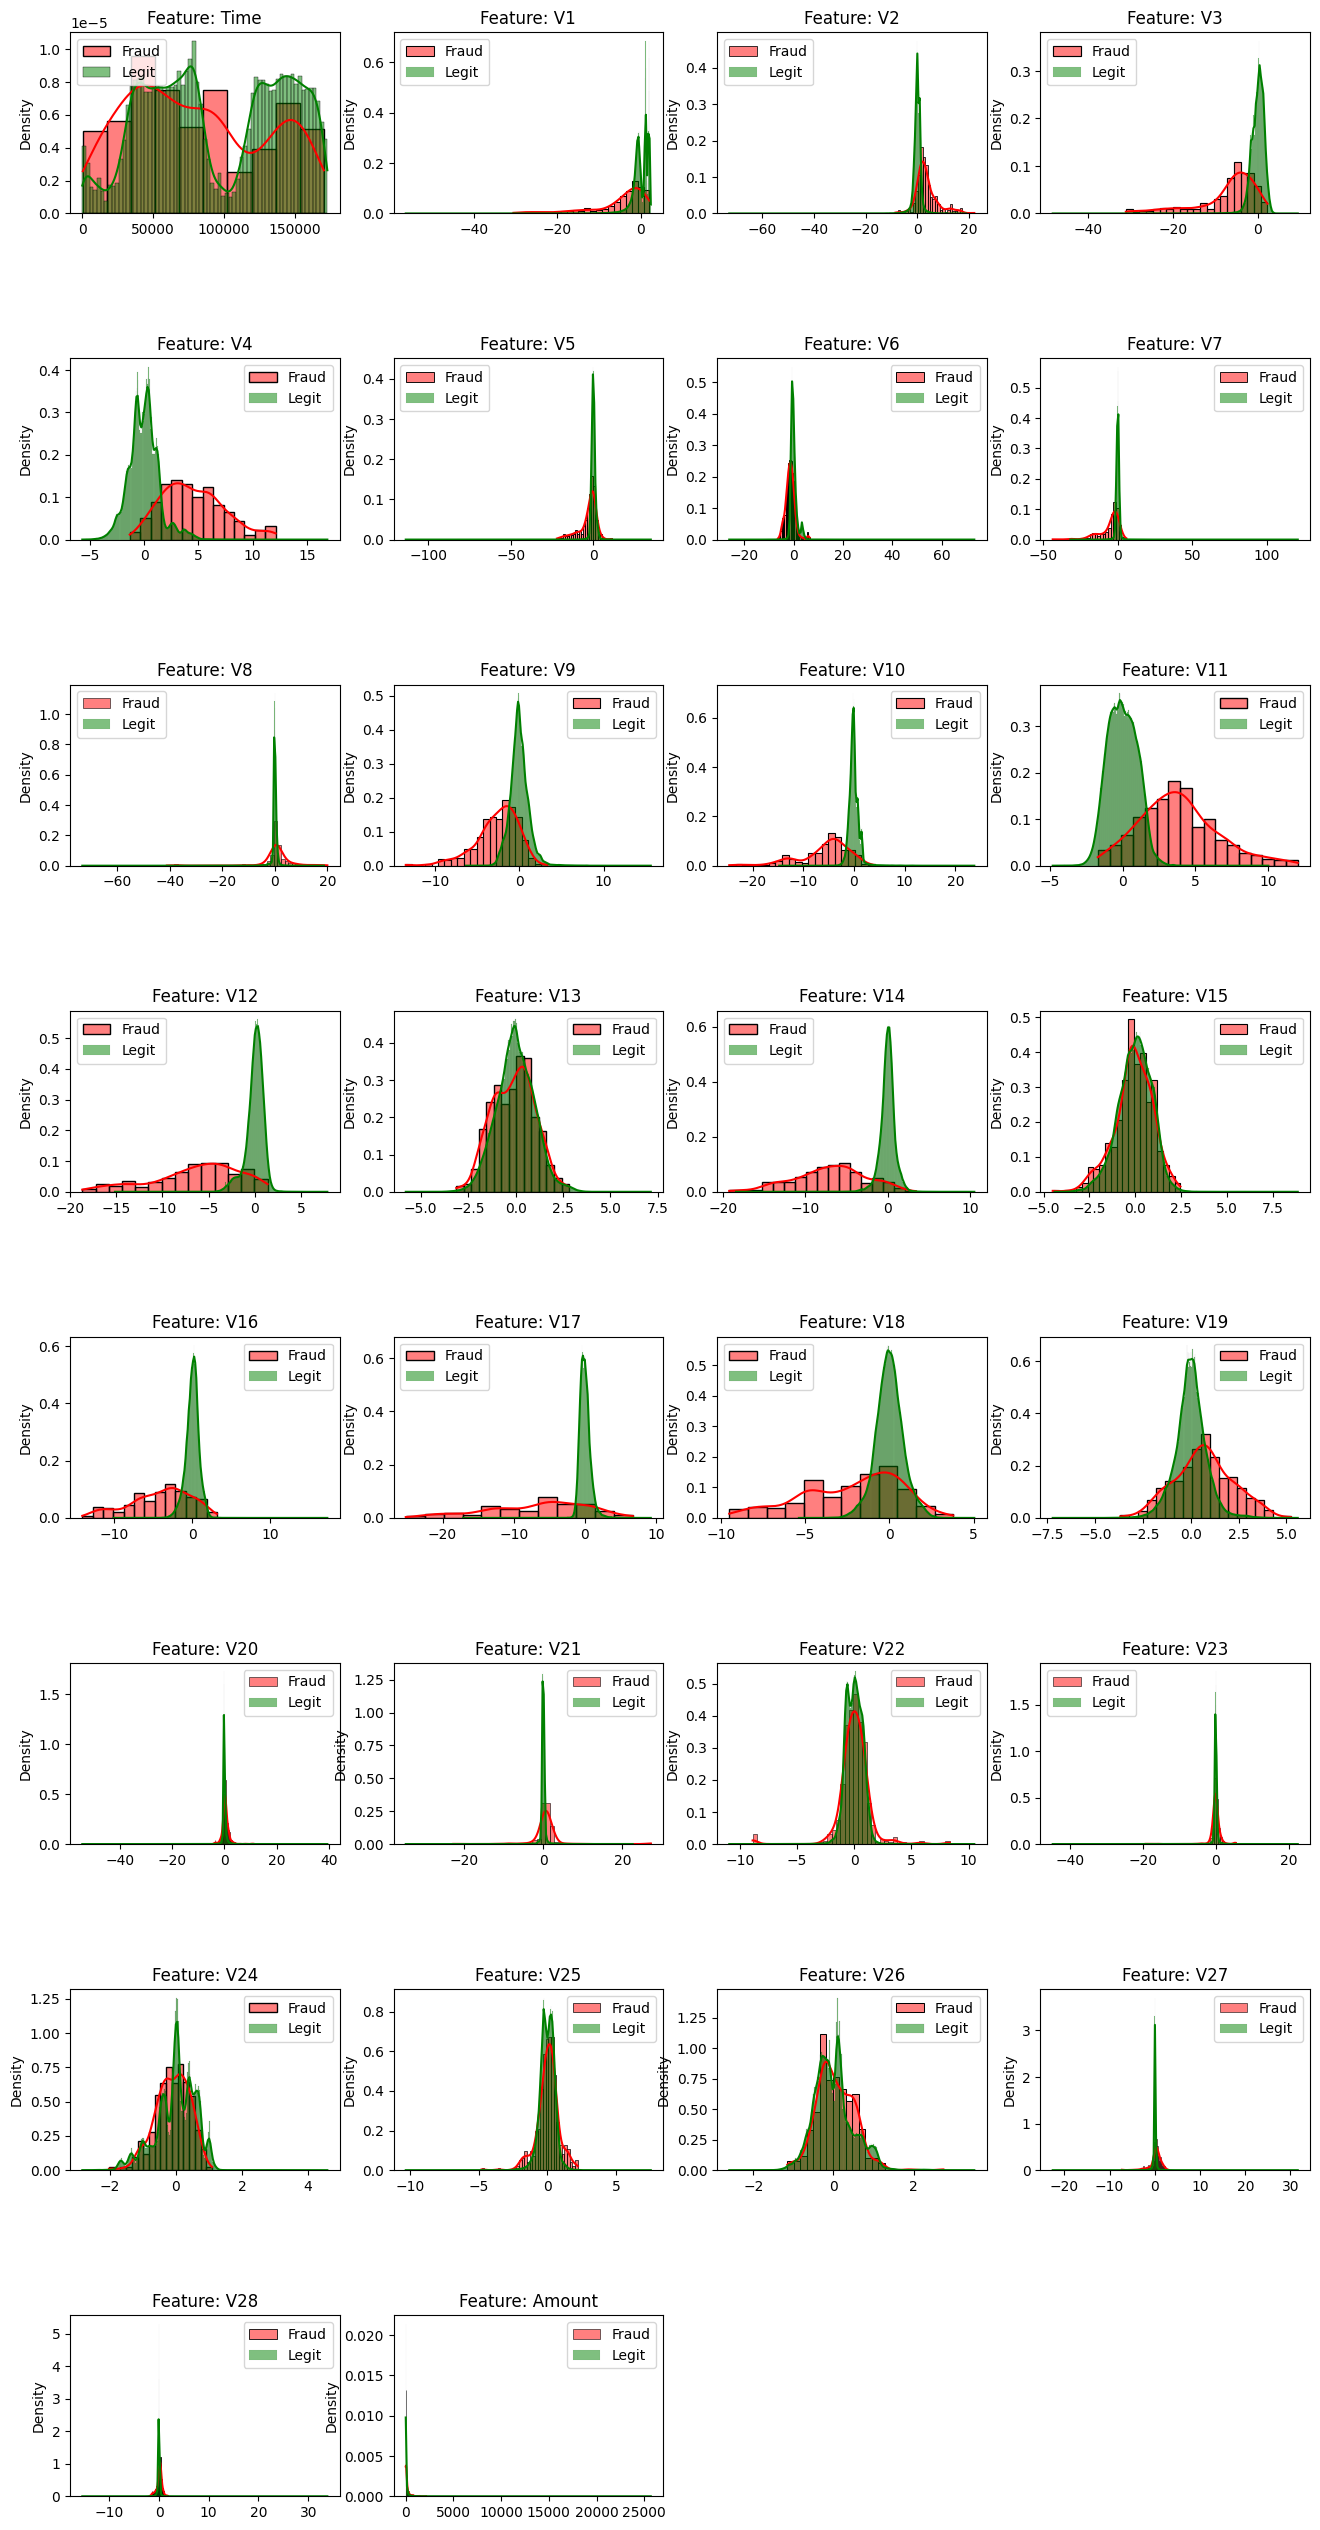

In [12]:
# Representamos gráficamente las características
features = df.drop("Class", axis=1)

plt.figure(figsize=(16, 32))
gs = gridspec.GridSpec(8, 4)
gs.update(hspace=0.8)

for i, f in enumerate(features):
    ax = plt.subplot(gs[i])
    # Usando histplot para los casos donde Class == 1
    sns.histplot(data=df[df["Class"] == 1], x=f, kde=True, color="red", stat="density", label="Fraud", alpha=0.5)
    # Usando histplot para los casos donde Class == 0
    sns.histplot(data=df[df["Class"] == 0], x=f, kde=True, color="green", stat="density", label="Legit", alpha=0.5)
    ax.set_xlabel('')
    ax.set_title(f"Feature: {f}")
    ax.legend()

plt.show()

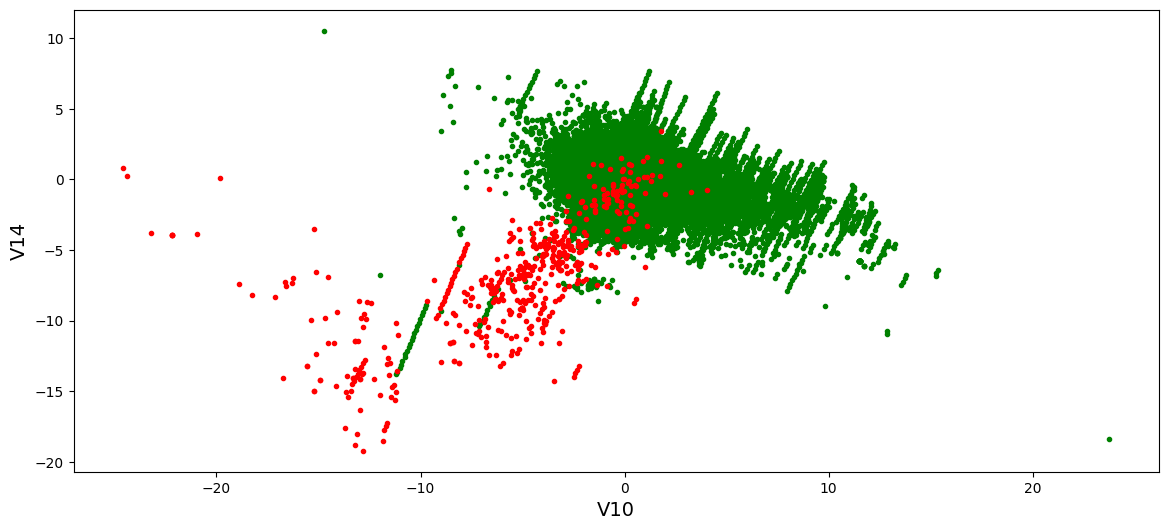

In [13]:
# Representación gráfica de dos características
plt.figure(figsize=(14, 6))
plt.scatter(df["V10"][df['Class'] == 0], df["V14"][df['Class'] == 0], c="g", marker=".")
plt.scatter(df["V10"][df['Class'] == 1], df["V14"][df['Class'] == 1], c="r", marker=".")
plt.xlabel("V10", fontsize=14)
plt.ylabel("V14", fontsize=14)
plt.show()

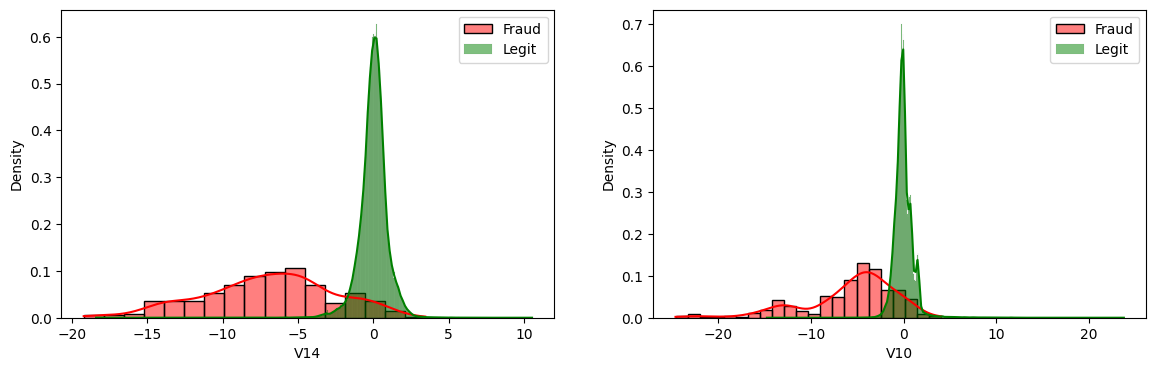

In [14]:
plt.figure(figsize=(14,4))
gs = gridspec.GridSpec(1, 2)

# Representación de la característica 1
ax = plt.subplot(gs[0])
sns.histplot(data=df[df['Class'] == 1], x="V14", kde=True, color="red", stat="density", label="Fraud", alpha=0.5)
sns.histplot(data=df[df['Class'] == 0], x="V14", kde=True, color="green", stat="density", label="Legit", alpha=0.5)
ax.legend()  # Para mostrar la leyenda

# Representación de la característica 2
ax = plt.subplot(gs[1])
sns.histplot(data=df[df['Class'] == 1], x="V10", kde=True, color="red", stat="density", label="Fraud", alpha=0.5)
sns.histplot(data=df[df['Class'] == 0], x="V10", kde=True, color="green", stat="density", label="Legit", alpha=0.5)
ax.legend()  # Para mostrar la leyenda

plt.show()

## 3. Preparación del conjunto de datos

Para este tipo de algoritmos es importante que todos los datos se encuentren en un rango similar, por lo tanto, podemos aplicar una función de escalado o normalización. Otra opción, es eliminar las características que no se encuentran en un rango similar siempre y cuando no sean muy influyentes para la predicción.

In [15]:
df_prep = df.drop(["Time", "Amount"], axis=1)

## 4. Distribución Gaussiana con un conjunto de datos de dos dimensiones

Antes de comenzar con la detección de anomalías mediante distribución Gaussiana para todos los atributos del conjunto de datos, se realiza una prueba para dos atributos con el objetivo de comprender como construye el límite de decisión.

In [16]:
X = df_prep.drop("Class", axis=1)
y = df_prep["Class"].copy()

In [17]:
X_reduced = X[["V10", "V14"]].copy()

**Entrenamiento del algoritmo con un conjunto de datos reducido**

In [18]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=2, random_state=42)
gm.fit(X_reduced)

s:\SOFTWARE\ANACONA\envs\IBMmachienlearning\Lib\site-packages\joblib\externals\loky\backend\context.py:131: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] El sistema no puede encontrar el archivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "s:\SOFTWARE\ANACONA\envs\IBMmachienlearning\Lib\site-packages\joblib\externals\loky\backend\context.py", line 247, in _count_physical_cores
    cpu_count_physical = _count_physical_cores_win32()
  File "s:\SOFTWARE\ANACONA\envs\IBMmachienlearning\Lib\site-packages\joblib\externals\loky\backend\context.py", line 299, in _count_physical_cores_win32
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "s:\SOFTWARE\ANACONA\envs\IBMmachienlearning\Lib\subprocess.py", line 55

,n_components,2
,covariance_type,'full'
,tol,0.001
,reg_covar,1e-06
,max_iter,100
,n_init,1
,init_params,'kmeans'
,weights_init,None
,means_init,None
,precisions_init,None
,random_state,42


**Representación del límite de decisión**

In [19]:
def plot_gaussian_mixture(clusterer, X, y, resolution=1000):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], 'k.', markersize=2)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], 'r.', markersize=2)

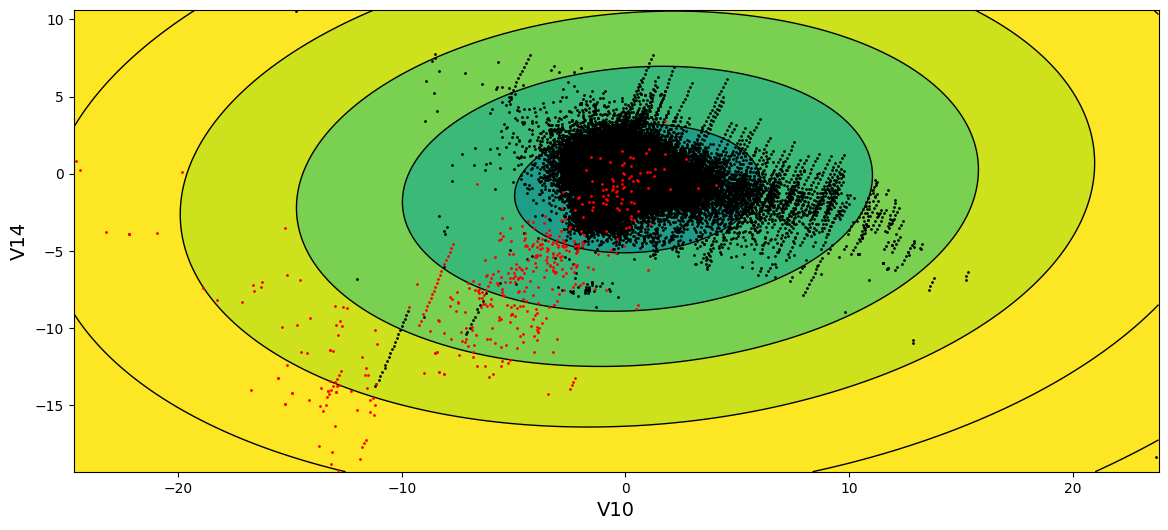

In [20]:
plt.figure(figsize=(14, 6))
plot_gaussian_mixture(gm, X_reduced.values, y)
plt.xlabel("V10", fontsize=14)
plt.ylabel("V14", fontsize=14)
plt.show()

**Representación de las anomalías identificadas**

Para la identificación de las anomalías, se debe seleccionar un threshold a partir del cual, todos los ejemplos que se encuentren en regiones con una densidad menor a la indicada en el threshold, se consideran anomalías.

In [27]:
# Selección del Threshold
densities = gm.score_samples(X_reduced)
density_threshold = np.percentile(densities, 0.4)
print("Threshold seleccionado:", density_threshold)

Threshold seleccionado: -9.602481846462945


In [28]:
# Identificación de anomalías
anomalies = X_reduced.values[densities < density_threshold]

En la gráfica que se muestra a continuación, aparecen resltadas en verde las anomalías identificadas para el conjunto de datos de entrenamiento y el valor del threshold seleccionado anteriormente.

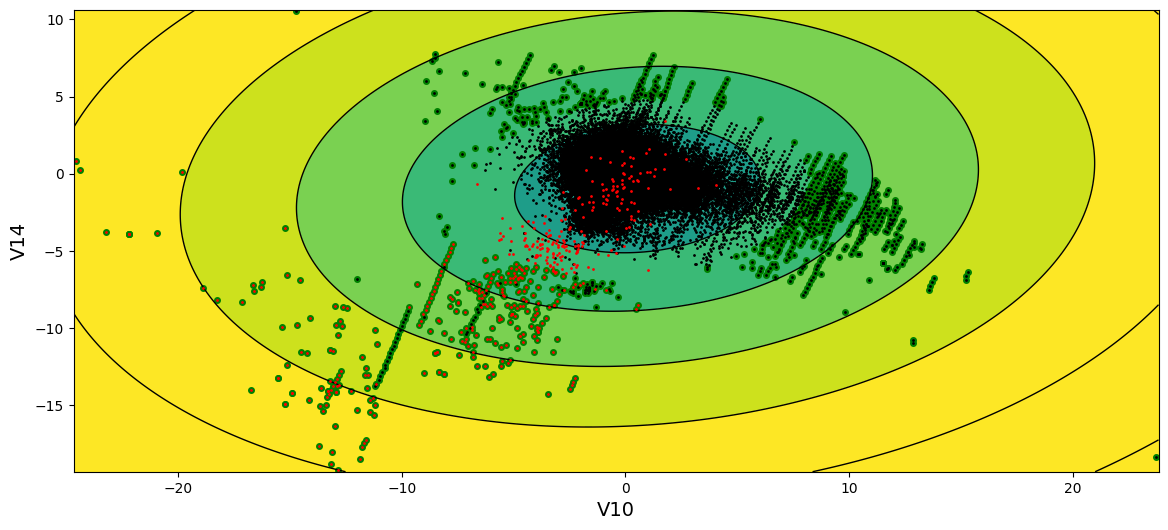

In [29]:
# Representación gráfica de las anomalías
plt.figure(figsize=(14, 6))
plt.plot(anomalies[:, 0], anomalies[:, 1], 'go', markersize=4)
plot_gaussian_mixture(gm, X_reduced.values, y)
plt.xlabel("V10", fontsize=14)
plt.ylabel("V14", fontsize=14)
plt.show()

**Predicción con el conjunto de datos reducido**

In [30]:
# Comparación de cuantas anomalías se correspondían con ejemplos fraudulentos
y_preds = (densities < density_threshold)
y_preds[y_preds == False] = 0
y_preds[y_preds == True] = 1

In [31]:
# Clases originales
y.value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [32]:
# Casos identificados como anomalías etiquetados como negativos (0) y positivos (1)
y[y_preds==1].value_counts()

Class
0    847
1    293
Name: count, dtype: int64

## 5. Distribución Gaussiana con un conjunto de datos multidimensional

In [33]:
# Entrenamiento del modelo
gm = GaussianMixture(n_components=2, random_state=42)
gm.fit(X)

,n_components,2
,covariance_type,'full'
,tol,0.001
,reg_covar,1e-06
,max_iter,100
,n_init,1
,init_params,'kmeans'
,weights_init,None
,means_init,None
,precisions_init,None
,random_state,42


In [34]:
# Selección del Threshold
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 0.1)
print("Threshold seleccionado:", density_threshold)

Threshold seleccionado: -410.384902350729


In [35]:
# Comparación de cuantas anomalías se correspondían con ejemplos fraudulentos
y_preds = (densities < -470)
y_preds[y_preds == False] = 0
y_preds[y_preds == True] = 1

In [36]:
# Casos identificados como anomalías etiquetados como negativos (0) y positivos (1)
y[y_preds==1].value_counts()

Class
0    135
1    100
Name: count, dtype: int64

## 6. Búsqueda del mejor Threshold

Existen varias formas de realizar la búsqueda del Threshold automáticamente:

In [37]:
from sklearn.base import BaseEstimator

class GaussianAnomalyDetector(BaseEstimator):
    def __init__(self, threshold=1):
        self._threshold = threshold
        self._gm = None
    def fit(self, X, y=None):
        self._gm = GaussianMixture(n_components=2, n_init=10, random_state=42)
        self._gm.fit(X) 
        return self
    
    def predict(self, X, y=None):
        densities = self._gm.score_samples(X)
        y_preds = (densities < self._threshold)
        y_preds[y_preds == False] = 0
        y_preds[y_preds == True] = 1
        return y_preds
    
    def get_params(self, deep=True):
        return {"threshold": self._threshold}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
            return self

In [38]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

gad = GaussianAnomalyDetector()

param_distribs = {
    # Utiliza 'uniform' para distribuciones continuas. 
    # 'loc' es el inicio del rango y 'scale' es la anchura del rango (el total de valores en el rango).
    'threshold': uniform(loc=0.01, scale=4.99),
}

# Configuración de RandomizedSearchCV (5*3=15 rondas de entrenamiento)
rnd_search = RandomizedSearchCV(gad, param_distributions=param_distribs,
                                n_iter=5, cv=3, scoring='f1')

# Entrenamiento del modelo
rnd_search.fit(X, y)

KeyboardInterrupt: 

In [31]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.005938965991800008 {'threshold': 4.296838862550599}
0.005938965991800008 {'threshold': 0.42078038597687645}
0.005938965991800008 {'threshold': 2.0240071979446483}
0.005938965991800008 {'threshold': 4.705462330815801}
0.005938965991800008 {'threshold': 3.8361622822270416}


La forma mostrada anteriormente es la más estándar a la hora de realizar la búsqueda, pero también es la más ineficiente. Con el método anterior se requiere entrenar el modelo 15 veces (con los parámetro indicados). 

Con la forma que se muestra a continuación solo es necesario entrenar el modelo una única vez.

In [32]:
from sklearn.metrics import precision_score

def select_threshold(list_thds, densities, y):
    best_prec = 0
    best_threshold = 0
    i = 0
    for thd in list_thds:
        i += 1
        print("\rSearching best threshold {0}%".format(
            int((i + 1) / len(list_thds) * 100)), end='')
        preds = (densities < thd)
        preds[preds == False] = 0
        preds[preds == True] = 1
        precision = precision_score(y, preds)
        if precision > best_prec:
            best_prec = precision
            best_threshold = thd
    return (best_prec, best_threshold)

In [33]:
select_threshold(np.arange(-600, -300, 1), densities, y)

Searching best threshold 100%

(0.425531914893617, -470)